https://nuance.readthedocs.io/en/latest/notebooks/tutorials/tess_search.html

# TESS search

In this tutorial we use nuance to search for the known planetary companion [TOI-540 b](https://exofop.ipac.caltech.edu/tess/target.php?id=200322593)

```{note}
This tutorial requires the `lightkurve` package to access the data
```

In order to run this tutorial on all available CPUs, we set the `XLA_FLAGS` env variable to

In [1]:
import sys

!{sys.executable} -m pip show nuance

Name: nuance
Version: 0.7.1
Summary: Transit signals detection among correlated noises
Home-page: 
Author: Lionel Garcia
Author-email: 
License: 
Location: /ut3/jerome/miniconda3/envs/nuance/lib/python3.12/site-packages
Requires: jax, jaxlib, jaxopt, matplotlib, multiprocess, numpy, scipy, tinygp, tqdm
Required-by: 


In [3]:
import os
import jax

jax.config.update("jax_enable_x64", True)
# os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={os.cpu_count()}"

## Download

We start by downloading the data using the `lightkurve` package

In [16]:
import matplotlib.pyplot as plt
import lightkurve as lk
import numpy as np

# single sector
lc = lk.search_lightcurve("TIC 89071445", author="QLP")[0].download().remove_outliers()

# masking nans
time = lc.time.to_value("btjd")
flux = lc.flux.to_value()
error = lc.flux_err.to_value()
mask = np.isnan(flux) | np.isnan(error) | np.isnan(time)
time = time[~mask].astype(float)
flux = flux[~mask].astype(float)
error = error[~mask].astype(float)

# normalize
flux_median = np.median(flux)
flux /= flux_median
error /= flux_median

Let's plot the light curve.

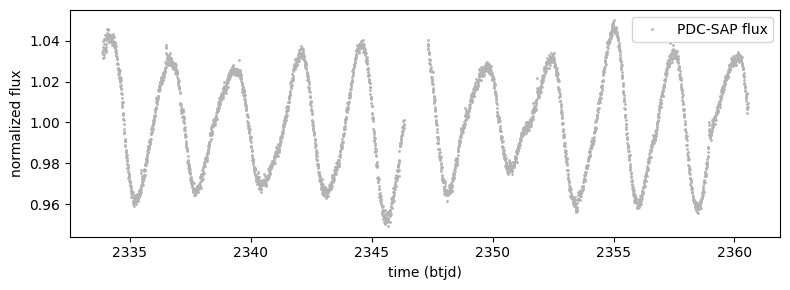

In [17]:
plt.figure(figsize=(8, 3))
plt.plot(time, flux, ".", c="0.7", ms=2, label="PDC-SAP flux")
plt.xlabel("time (btjd)")
plt.ylabel("normalized flux")
plt.legend()
plt.tight_layout()

We see that TOI-540 display some stellar variability, likely due to the presence of starspots rotating with the star. A traditional approach consists in modeling and removing this signal before searching for transits, which could affect the transit signal themselves. Luckily, nuance is equipped to search for transits while modeling stellar variability.

```{note}
For this tutorial we decided to focus on a single TESS sector, but searching and combining different TESS sectors can be done following the approach presented in the [ground-based search tutorial](./ground_based.ipynb).
```

## GP kernel optimization

The next step is to define and optimize the GP kernel that will help model the covariance of the data (mostly stellar variability). Here, we will use a mixture of two SHO kernels, implemented in `nuance.kernels` and representative of a wide range of stellar variability signals.

In [18]:
from nuance.kernels import rotation
from nuance.utils import minimize
from nuance.core import gp_model

# rotation period from literature or Lomb-Scargle
star_period = 2.59

build_gp, init = rotation(star_period, error.mean(), long_scale=0.5)
mu, nll = gp_model(time, flux, build_gp)

# optimization
gp_params = minimize(
    nll, init, ["log_sigma", "log_short_scale", "log_short_sigma", "log_long_sigma"]
)
gp_params = minimize(nll, gp_params)

## Flare masking

As flares and other astrophysical signals are not part of our model, we need to mask them. We do that iteratively while reoptimizing the GP kernel on every iteration.

In [19]:
from nuance.utils import sigma_clip_mask

flare_mask = np.ones_like(time).astype(bool)

for _ in range(3):
    residuals = flux - mu(gp_params)
    flare_mask = flare_mask & sigma_clip_mask(residuals, sigma=4.0, window=20)
    gp_params = minimize(nll, gp_params)

time_masked = time[flare_mask]
flux_masked = flux[flare_mask]

Let's see the cleaned light curve

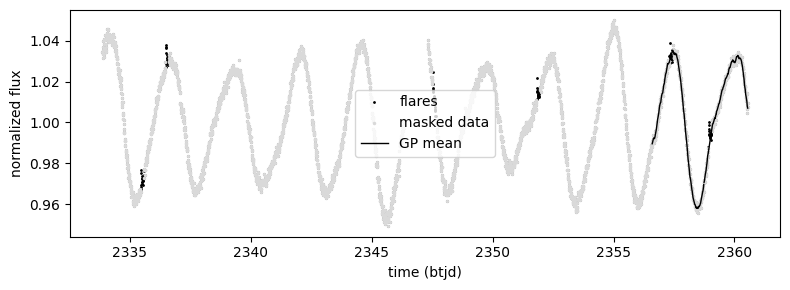

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 3))
plt.plot(time, flux, ".", c="k", ms=2, label="flares")
plt.plot(time_masked, flux_masked, ".", c="0.85", ms=3, label="masked data")

mu, _ = gp_model(time_masked, flux_masked, build_gp)
gp_mean = mu(gp_params)
split_idxs = [
    0,
    *np.flatnonzero(np.diff(time) > 10 / 60 / 24),
    len(time),
]

_ = True
for i in range(len(split_idxs) - 1):
    x = time_masked[split_idxs[i] + 1 : split_idxs[i + 1]]
    y = gp_mean[split_idxs[i] + 1 : split_idxs[i + 1]]
    plt.plot(x, y, "k", label="GP mean" if _ else None, lw=1)
    _ = False

plt.xlabel("time (btjd)")
plt.ylabel("normalized flux")
plt.legend()
plt.tight_layout()

In [21]:
gp = build_gp(gp_params, time_masked)

## Transit search

All the above is data preparation, now is time to actually search the cleaned light curve.

### Linear search

As usual, we start by defining a duration and epoch grid, and run the [`linear_search`](nuance.linear_search)

In [22]:
from nuance.linear_search import linear_search

epochs = time_masked.copy()
durations = np.linspace(10 / 60 / 24, 2 / 24, 8)

ls = linear_search(time_masked, flux_masked, gp=gp)(epochs, durations)

  0%|          | 0.00/3.57k [00:00<?, ?it/s]

### Periodic search

We can then define an optimal period grid following [Ofir (2014)](https://ui.adsabs.harvard.edu/abs/2014A%26A...561A.138O/abstract) (Eq. 7)

In [9]:
from nuance import Star

star = Star(radius=0.189, mass=0.159)
periods = star.period_grid(np.ptp(time_masked), oversampling=5)

and run the [`periodic_search`](nuance.periodic_search)

In [10]:
from nuance import core
from nuance.periodic_search import periodic_search

snr_function = jax.jit(core.snr(time_masked, flux_masked, gp=gp))
ps_function = periodic_search(epochs, durations, ls, snr_function)
snr, params = ps_function(periods)

/opt/homebrew/Caskroom/miniforge/base/envs/nuance/lib/python3.10/site-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/11745 [00:00<?, ?it/s]

### Result

We can retrieve the best (maximum-SNR) transit parameters with

In [11]:
t0, D, P = params[np.argmax(snr)]
max_snr = np.max(snr)
depth, depth_error, _ = core.solve(time_masked, flux_masked, gp=gp)(t0, D, P)

print("\tExoFOP\tnuance")
print(f"period\t1.23915\t{P:.5f}")
print(f"durat.\t{2318.65*1e-6:.5f}\t{depth:.5f}\t days")
print(f"depth\t{0.4887/24:.5f}\t{D:.5f}\t days")
print(f"snr\t17.9\t{max_snr:.1f}")
print(f"sectors\t5\t1")

	ExoFOP	nuance
period	1.23915	1.23916
durat.	0.00232	0.00185	 days
depth	0.02036	0.01786	 days
snr	17.9	8.7
sectors	5	1


and plot the periodogram and phase-folded light curve with

/var/folders/7v/d8bs1hz144s2ypqglv245hp40000gn/T/ipykernel_10984/741865150.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


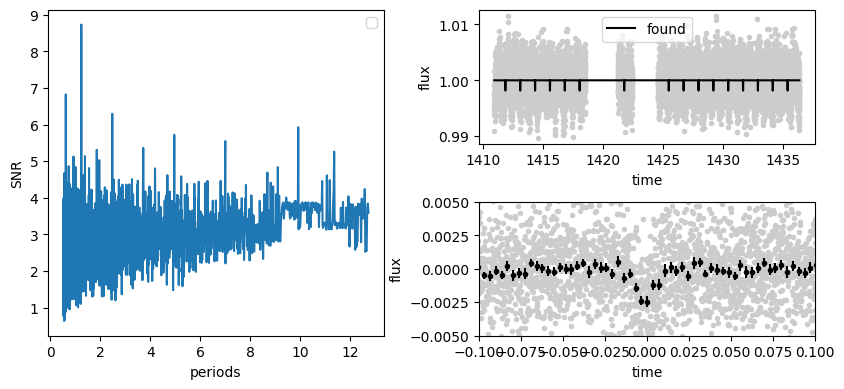

In [12]:
from nuance import utils

fig = plt.figure(figsize=(8.5, 4))

linear, found, noise = core.separate_models(time_masked, flux_masked, gp=gp)(t0, D, P)

ax = plt.subplot(121, xlabel="periods", ylabel="SNR")
ax.plot(periods, snr)
ax.legend()

ax = plt.subplot(222, xlabel="time", ylabel="flux")
ax.plot(time_masked, flux_masked, ".", c="0.8")
ax.plot(time_masked, found + 1, c="k", label="found")

ax.legend()

ax = plt.subplot(
    224, xlabel="time", ylabel="flux", xlim=(-0.1, 0.1), ylim=(-0.005, 0.005)
)
phi = utils.phase(time_masked, t0, P)
detrended = flux_masked - noise - linear
plt.plot(phi, detrended, ".", c=".8")
bx, by, be = utils.binn_time(phi, detrended, bins=5 / 60 / 24)
plt.errorbar(bx, by, yerr=be, fmt=".", c="k")

plt.tight_layout()